# GAE

In [1]:
import pandas as pd 
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.nn import GCNConv, GAE
from torch.nn import Module
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling

model: GAE
optimizer: torch.optim.Adam

class GCNEncoder(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 70)
        self.conv2 = GCNConv(70, 50)
        self.conv3 = GCNConv(50, out_channels)

    def forward(self, x, edge_index, edge_weight, batch=None):
        x = F.tanh(self.conv1(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv2(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv3(x, edge_index=edge_index, edge_weight=edge_weight))
        return x

def remove_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].reset_index(drop=True)

    return df

def data_standardization(df: pd.DataFrame, target: str):
    scaler = MinMaxScaler()

    df[target + '_original'] = df[target]
    scaler = scaler.fit(df[[target]])
    df[target] = scaler.transform(df[[target]])

    return df

def read_train_data(data: pd.DataFrame):
    training_dataset = []

    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except:
            pass
    
    input_dim : int = training_dataset[0].x.shape[1]

    return training_dataset, input_dim

def create_train_and_validation_dataset(training_dataset: list) -> tuple[list, list]:
    print(f'Spliting data into training dataset and validation dataset.')

    dist = 0.90

    dataset_len = len(training_dataset)

    train_dataset = training_dataset[:int(dataset_len*dist)]
    val_dataset = training_dataset[int(dataset_len*dist):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')

    return train_dataset, val_dataset

def create_batches(train_dataset: list, val_dataset: list, batch_size: int) -> tuple[list, list]:
    print(f'Creating batches.')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

def train_model(train_loader):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
        batch_size = data.y.size(0)  # Number of samples in the batch
        total_loss += loss.item() * batch_size  # Weight loss by batch size
        total_samples += batch_size

        return total_loss / total_samples if total_samples > 0 else 0
    
def validate_model(val_loader):
    model.eval()
    total_val_loss = 0
    total_val_samples = 0
    all_pos_edges, all_neg_edges, all_z = [], [], []
    
    with torch.no_grad():
        for data in val_loader:
            z = model.encode(data.x, data.edge_index, data.edge_weight)
            loss = model.recon_loss(z, data.edge_index)
            batch_size = data.num_nodes  # Use num_nodes for per-node loss weighting
            total_val_loss += loss.item() * batch_size
            total_val_samples += batch_size
            
            # For AUC: Collect for aggregated evaluation
            all_z.append(z)
            all_pos_edges.append(data.edge_index)
            neg_edge_index = negative_sampling(data.edge_index, z.size(0))
            all_neg_edges.append(neg_edge_index)
    
    avg_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else 0
    
    # Aggregated AUC
    z_cat = torch.cat(all_z, dim=0)
    pos_cat = torch.cat(all_pos_edges, dim=1)
    neg_cat = torch.cat(all_neg_edges, dim=1)
    auc, ap = model.test(z_cat, pos_cat, neg_cat)
    
    return avg_val_loss, auc, ap

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')

df = remove_outliers(df, 'static_polarizability')
df = data_standardization(df, 'static_polarizability')

traning_dataset, input_dim = read_train_data(df)
train_dataset, val_dataset = create_train_and_validation_dataset(traning_dataset)
train_loader, val_loader = create_batches(train_dataset, val_dataset, 16)


Reading training data.


25638it [00:08, 3139.25it/s]

Spliting data into training dataset and validation dataset.
Number of training graphs: 22739
Number of validation graphs: 2527
Creating batches.


In [4]:
encoder = GCNEncoder(input_dim, 40)
model = GAE(encoder=encoder)  # Uses default InnerProductDecoder
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
epochs = 300
best_val_loss = float('inf')
patience = 50
counter = 0

metrics = pd.DataFrame()

for epoch in range(epochs):
    train_loss = train_model(train_loader)  # Fix to accumulate over all batches
    val_loss, val_auc, ap = validate_model(val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {ap:.4f}')
    metrics = pd.concat([metrics, pd.DataFrame({'train_loss': train_loss, 'val_loss': val_loss, 'val_auc': val_auc, 'val_ap': ap}, index=[0])])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model, 'best_gae_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1, Train Loss: 1.6608, Val Loss: 1.6612, Val AUC: 0.6544, Val AP: 0.6552
Epoch 2, Train Loss: 1.6570, Val Loss: 1.6337, Val AUC: 0.6448, Val AP: 0.6497
Epoch 3, Train Loss: 1.6813, Val Loss: 1.6030, Val AUC: 0.6565, Val AP: 0.6530
Epoch 4, Train Loss: 1.5590, Val Loss: 1.5746, Val AUC: 0.6511, Val AP: 0.6473
Epoch 5, Train Loss: 1.6021, Val Loss: 1.5502, Val AUC: 0.6460, Val AP: 0.6432
Epoch 6, Train Loss: 1.5889, Val Loss: 1.5235, Val AUC: 0.6868, Val AP: 0.6868
Epoch 7, Train Loss: 1.5411, Val Loss: 1.4973, Val AUC: 0.7018, Val AP: 0.6886
Epoch 8, Train Loss: 1.4856, Val Loss: 1.4759, Val AUC: 0.6691, Val AP: 0.6652
Epoch 9, Train Loss: 1.5315, Val Loss: 1.4561, Val AUC: 0.6682, Val AP: 0.6570
Epoch 10, Train Loss: 1.4837, Val Loss: 1.4291, Val AUC: 0.6761, Val AP: 0.6757
Epoch 11, Train Loss: 1.4263, Val Loss: 1.4123, Val AUC: 0.6886, Val AP: 0.6821
Epoch 12, Train Loss: 1.4228, Val Loss: 1.3953, Val AUC: 0.6901, Val AP: 0.6824
Epoch 13, Train Loss: 1.3928, Val Loss: 1.3782, V

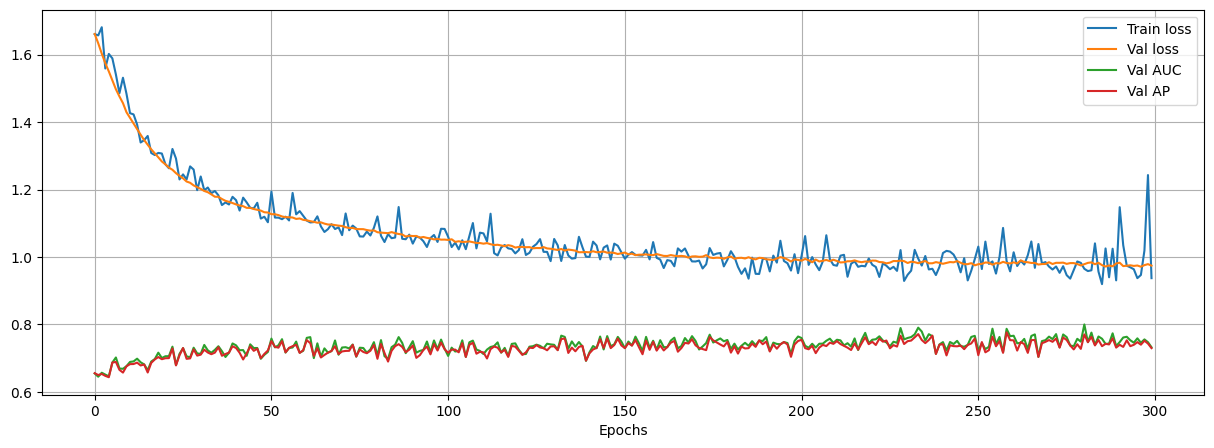

In [10]:
import matplotlib.pyplot as plt

metrics = metrics.reset_index(drop=True)

plt.figure(figsize=(15,5))
plt.plot(metrics.index, metrics['train_loss'], label='Train loss')
plt.plot(metrics.index, metrics['val_loss'], label='Val loss')
plt.plot(metrics.index, metrics['val_auc'], label='Val AUC')
plt.plot(metrics.index, metrics['val_ap'], label='Val AP')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

# VGAE

In [26]:
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.utils import negative_sampling, to_dense_adj
from torch.nn import Module
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class VariationalGCNEncoder(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 70)
        self.conv2 = GCNConv(70, 50)
        self.conv_mu = GCNConv(50, out_channels)
        self.conv_logstd = GCNConv(50, out_channels)

    def forward(self, x, edge_index, edge_weight, batch=None):
        x = F.tanh(self.conv1(x, edge_index=edge_index, edge_weight=edge_weight))
        x = F.tanh(self.conv2(x, edge_index=edge_index, edge_weight=edge_weight))
        mu = self.conv_mu(x, edge_index=edge_index, edge_weight=edge_weight)
        logstd = self.conv_logstd(x, edge_index=edge_index, edge_weight=edge_weight)
        return mu, logstd

class FeatureDecoder(Module):
    def __init__(self, latent_dim, feature_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(latent_dim, 32)
        self.fc2 = torch.nn.Linear(32, feature_dim)

    def forward(self, z):
        return torch.sigmoid(self.fc2(F.relu(self.fc1(z))))  # Sigmoid for binary probabilities

class EnhancedVGAE(VGAE):
    def __init__(self, encoder, feature_dim, latent_dim):
        super().__init__(encoder)
        self.feature_decoder = FeatureDecoder(latent_dim, feature_dim)

    def feature_decode(self, z):
        return self.feature_decoder(z)

def remove_outliers(df: pd.DataFrame, target: str) -> pd.DataFrame:
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].reset_index(drop=True)
    return df

def data_standardization(df: pd.DataFrame, target: str):
    scaler = MinMaxScaler()
    df[target + '_original'] = df[target]
    scaler = scaler.fit(df[[target]])
    df[target] = scaler.transform(df[[target]])
    return df

def read_train_data(data: pd.DataFrame):
    training_dataset = []
    print(f'Reading training data.')
    for row in tqdm(data.itertuples()):
        try:
            training_dataset.append(torch.load(f'../polygraphpy/data/training_input_data/{row.id}_{row.chain_size}.pt', weights_only=False))
        except:
            pass
    input_dim = training_dataset[0].x.shape[1]
    return training_dataset, input_dim

def create_train_and_validation_dataset(training_dataset: list) -> tuple[list, list]:
    print(f'Splitting data into training dataset and validation dataset.')
    dist = 0.90
    dataset_len = len(training_dataset)
    train_dataset = training_dataset[:int(dataset_len*dist)]
    val_dataset = training_dataset[int(dataset_len*dist):]
    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of validation graphs: {len(val_dataset)}')
    return train_dataset, val_dataset

def create_batches(train_dataset: list, val_dataset: list, batch_size: int) -> tuple[list, list]:
    print(f'Creating batches.')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, val_loader

def train_vgae(train_loader, model, optimizer):
    model.train()
    total_loss = 0
    total_samples = 0

    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index, data.edge_weight, data.batch)
        neg_edge_index = negative_sampling(data.edge_index, z.size(0), num_neg_samples=data.edge_index.size(1)*5)
        recon_loss = model.recon_loss(z, data.edge_index, neg_edge_index)
        kl_loss = (100 / data.num_nodes) * model.kl_loss()
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        batch_size = data.num_nodes
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    return total_loss / total_samples if total_samples > 0 else 0

def train_feature_decoder(train_loader, model, feat_optimizer):
    model.eval()  # VGAE fixed during feature decoder training
    total_feat_loss = 0
    total_samples = 0

    for data in train_loader:
        feat_optimizer.zero_grad()

        with torch.no_grad():
            z = model.encode(data.x, data.edge_index, data.edge_weight, data.batch)

        x_hat = model.feature_decode(z)
        feat_loss = F.binary_cross_entropy(x_hat, data.x)  # BCE for binary features
        feat_loss.backward()
        feat_optimizer.step()
        batch_size = data.num_nodes
        total_feat_loss += feat_loss.item() * batch_size
        total_samples += batch_size

    return total_feat_loss / total_samples if total_samples > 0 else 0

def validate_model(val_loader, model):
    model.eval()
    total_val_loss = 0
    total_feat_loss = 0
    total_val_samples = 0
    all_pos_edges, all_neg_edges, all_z = [], [], []

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            z = model.encode(data.x, data.edge_index, data.edge_weight)
            neg_edge_index = negative_sampling(data.edge_index, z.size(0), num_neg_samples=data.edge_index.size(1)*5)
            recon_loss = model.recon_loss(z, data.edge_index, neg_edge_index)
            kl_loss = (100 / data.num_nodes) * model.kl_loss()
            loss = recon_loss + kl_loss

            x_hat = model.feature_decode(z)
            feat_loss = F.binary_cross_entropy(x_hat, data.x)
            batch_size = data.num_nodes
            total_val_loss += loss.item() * batch_size
            total_feat_loss += feat_loss.item() * batch_size

            total_val_samples += batch_size
            all_z.append(z)
            all_pos_edges.append(data.edge_index)
            neg_edge_index_val = negative_sampling(data.edge_index, z.size(0))
            all_neg_edges.append(neg_edge_index_val)
            
            #Print matrices for first 2 samples
            if np.mod(epoch,5) == 0:
                if i == 5:
                    adj_pred = model.decoder.forward_all(z, sigmoid=True)
                    adj_binary = (adj_pred > 0.5040).float()
                    print(f'Sample {i+1} Probabilistic Adjacency Pred:\n{adj_pred}')
                    print(f'Sample {i+1} Binary Adjacency Pred:\n{adj_binary}')
                    print(f'Sample {i+1} Binary Adjacency Real:\n{to_dense_adj(data.edge_index)}')
    
    avg_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else 0
    avg_feat_loss = total_feat_loss / total_val_samples if total_val_samples > 0 else 0
    z_cat = torch.cat(all_z, dim=0)
    pos_cat = torch.cat(all_pos_edges, dim=1)
    neg_cat = torch.cat(all_neg_edges, dim=1)
    auc, ap = model.test(z_cat, pos_cat, neg_cat)
    return avg_val_loss, avg_feat_loss, auc, ap

df = pd.read_csv('../polygraphpy/data/polarizability_data.csv')

df = df.head(3000)

df = remove_outliers(df, 'static_polarizability')
df = data_standardization(df, 'static_polarizability')
training_dataset, input_dim = read_train_data(df)
train_dataset, val_dataset = create_train_and_validation_dataset(training_dataset)
train_loader, val_loader = create_batches(train_dataset, val_dataset, 8)

latent_dim = 25
encoder = VariationalGCNEncoder(input_dim, latent_dim)
model = EnhancedVGAE(encoder, input_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # For VGAE
feat_optimizer = torch.optim.Adam(model.feature_decoder.parameters(), lr=0.001)  # Separate for feature decoder

Reading training data.


2887it [00:00, 4979.41it/s]

Splitting data into training dataset and validation dataset.
Number of training graphs: 2598
Number of validation graphs: 289
Creating batches.


In [27]:
epochs = 30
best_val_loss = float('inf')
patience = 10
counter = 0
metrics = pd.DataFrame()

print('Training neural net')
for epoch in range(epochs):
    train_loss = train_vgae(train_loader, model, optimizer)
    train_feat_loss = train_feature_decoder(train_loader, model, feat_optimizer)
    val_loss, val_feat_loss, val_auc, ap = validate_model(val_loader, model)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Feat Loss: {train_feat_loss:.4f}, Val Loss: {val_loss:.4f}, Val Feat Loss: {val_feat_loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {ap:.4f}')
    metrics = pd.concat([metrics, pd.DataFrame({'train_loss': train_loss, 'train_feat_loss': train_feat_loss, 'val_loss': val_loss, 
                                                'val_feat_loss': val_feat_loss, 'val_auc': val_auc, 'val_ap': ap}, index=[0])])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model, 'best_gae_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Training neural net
Sample 6 Probabilistic Adjacency Pred:
tensor([[0.8991, 0.8284, 0.8910,  ..., 0.3180, 0.2877, 0.3294],
        [0.8284, 0.7604, 0.8223,  ..., 0.3648, 0.3431, 0.3728],
        [0.8910, 0.8223, 0.8849,  ..., 0.3199, 0.2942, 0.3371],
        ...,
        [0.3180, 0.3648, 0.3199,  ..., 0.6561, 0.6424, 0.5177],
        [0.2877, 0.3431, 0.2942,  ..., 0.6424, 0.6448, 0.5605],
        [0.3294, 0.3728, 0.3371,  ..., 0.5177, 0.5605, 0.6765]])
Sample 6 Binary Adjacency Pred:
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])
Sample 6 Binary Adjacency Real:
tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
      

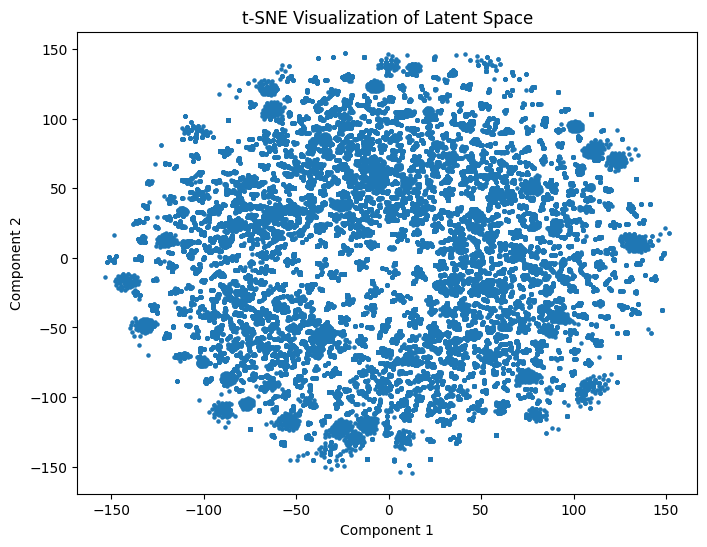

In [8]:
def visualize_latent_space(val_loader, model):
    model.eval()
    all_z = []
    with torch.no_grad():
        for data in val_loader:
            z = model.encode(data.x, data.edge_index, data.edge_weight)
            all_z.append(z)
    z_cat = torch.cat(all_z, dim=0).cpu().numpy()
    tsne = TSNE(n_components=2, perplexity=30)
    z_2d = tsne.fit_transform(z_cat)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], s=5)
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

visualize_latent_space(val_loader, model)